Forecasting time series , stationarity/independence, trend seasonal remainder, ARIMA model

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [2]:
COF = pd.read_csv("C:/Users/micls/OneDrive/Desktop/ML Projects/COF.csv", index_col='Date')
COF.index = pd.to_datetime(COF.index, format='%m/%d/%Y')  #change DATE to datetime object
COF.head()


,Adj Close
Date,
1994-11-16,3.835705
1994-11-17,3.895638
1994-11-18,3.955570
1994-11-21,3.865671
1994-11-22,3.685872


# Visualize the stock

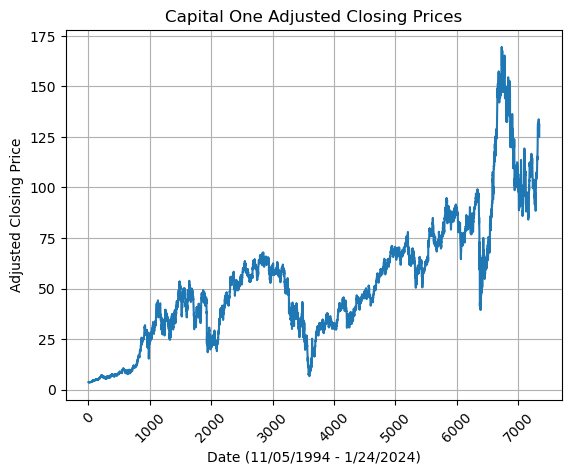

In [3]:
fig, ax = plt.subplots()
plt.plot(COF['Adj Close'].values)
plt.title('Capital One Adjusted Closing Prices')

plt.xlabel('Date (11/05/1994 - 1/24/2024)')
plt.xticks(rotation=45)
plt.ylabel('Adjusted Closing Price')
plt.grid()
plt.show()


Volatility

In [4]:
adj_diff = COF['Adj Close'].diff().dropna()

Date
1994-11-17    0.059933
1994-11-18    0.059932
1994-11-21   -0.089899
1994-11-22   -0.179799
1994-11-23   -0.029968
Name: Adj Close, dtype: float64


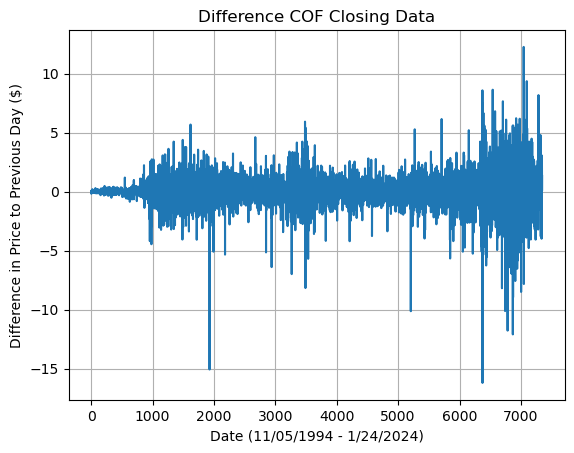

In [5]:
plt.plot(adj_diff.values)
plt.title('Difference COF Closing Data')
plt.ylabel('Difference in Price to Previous Day ($)')
plt.xlabel('Date (11/05/1994 - 1/24/2024)')

plt.grid();
print(adj_diff.head())

Adfuller test

If p value is higher than .05 , indicates non-stationarity aka relation to time. 

In [6]:
ACF = adfuller(COF['Adj Close'])
print('ADF Statistic: %f' % ACF[0])
print('p-value: %f' % ACF[1])
print('Critical Values:')
for key, value in ACF[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.162656
p-value: 0.689450
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Autocorrelation and differenced autocorrelation plots

Used to visualize stationarity and select arguments for ARIMA model. 

d: number of times differenced until stationary, here it is 1
p: number of signifigant lags in the PACF graph, here it is 2
q: number of signifigant lags in the differenced ACF plot, here it is 1



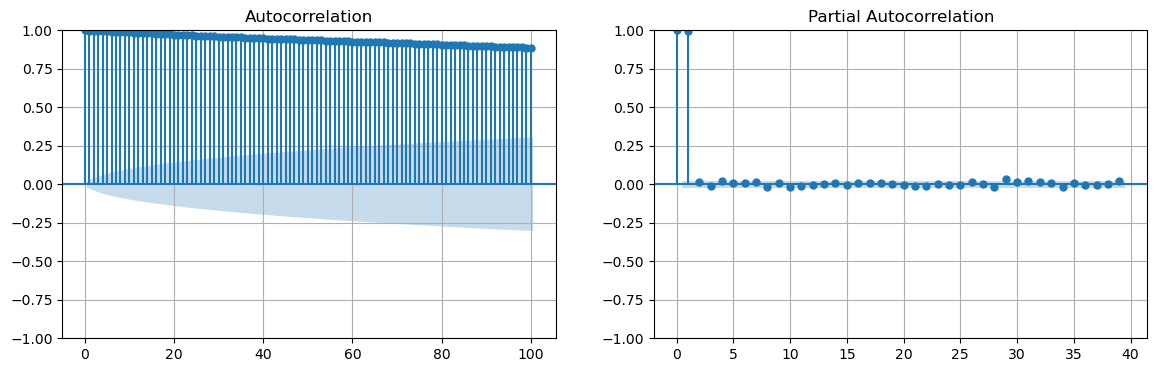

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
plot_acf(COF['Adj Close'].values, lags = 100,ax = ax[0]);
ax[0].grid()
plot_pacf(COF['Adj Close'].values, ax = ax[1])
ax[1].grid();

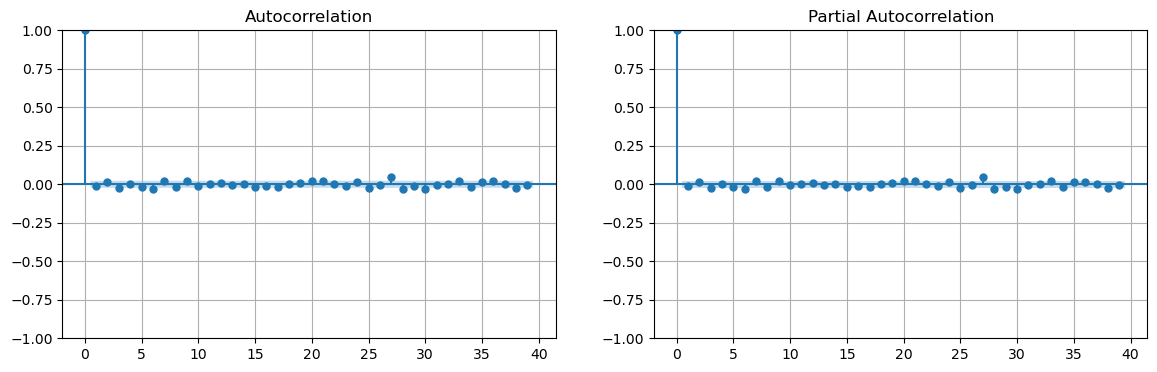

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
plot_acf(adj_diff, ax = ax[0]);
ax[0].grid()
plot_pacf(adj_diff, ax = ax[1])
ax[1].grid();

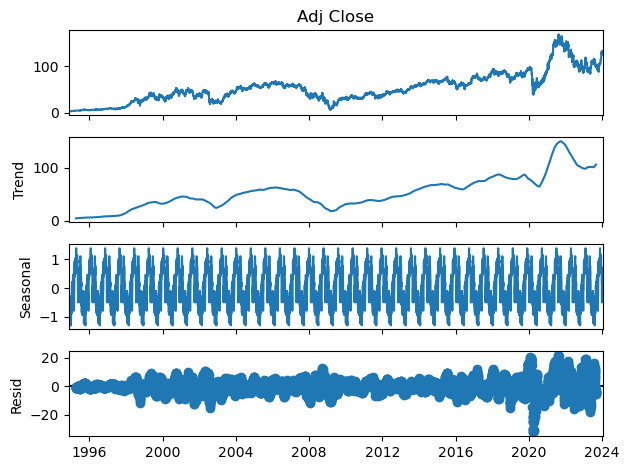

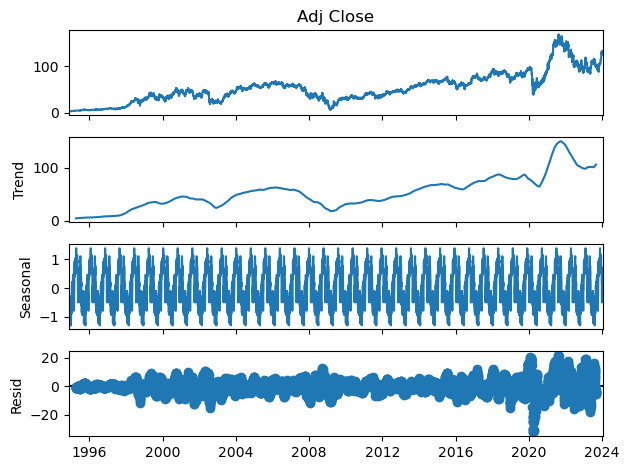

In [9]:
decomposed_COF = seasonal_decompose(COF['Adj Close'], period=200)
decomposed_COF.plot()

# Train test split into "historical" and "future" data. 

In [10]:
y_hist = COF[:'2023-06-01']
y_future = COF['2023-06-01':]
print('Historical:')
print(y_hist['Adj Close'].tail())
print('=========')
print('Future:')
print(y_future['Adj Close'].head())

Historical:
Date
2023-05-25     98.818359
2023-05-26    101.716057
2023-05-30    103.555550
2023-05-31    103.061058
2023-06-01    105.068680
Name: Adj Close, dtype: float64
Future:
Date
2023-06-01    105.068680
2023-06-02    109.271828
2023-06-05    107.798256
2023-06-06    110.784950
2023-06-07    112.288200
Name: Adj Close, dtype: float64


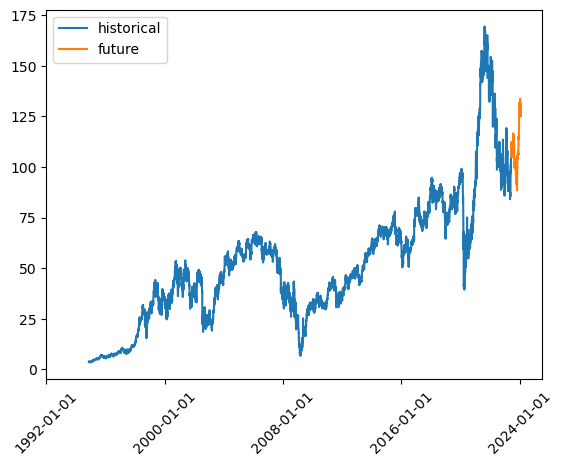

In [11]:
plt.plot(y_hist['Adj Close'], label = 'historical')
plt.plot(y_future['Adj Close'], label = 'future')
plt.xticks(rotation=45)
desired_ticks = 5
x_ticks = plt.xticks()[0]
selected_ticks = x_ticks[::len(x_ticks) // desired_ticks]
plt.xticks(selected_ticks)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


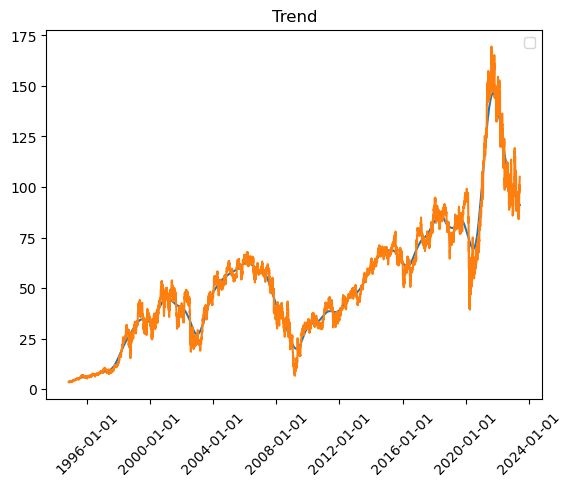

In [12]:
stl = STL(y_hist['Adj Close'], period = 200)
results = stl.fit()

plt.plot(results.trend)
plt.xticks(rotation=45)
desired_ticks = 5
x_ticks = plt.xticks()[0]
selected_ticks = x_ticks[::len(x_ticks) // desired_ticks]
plt.xticks(selected_ticks)
plt.plot(y_hist['Adj Close'])
plt.title('Trend')
plt.legend()

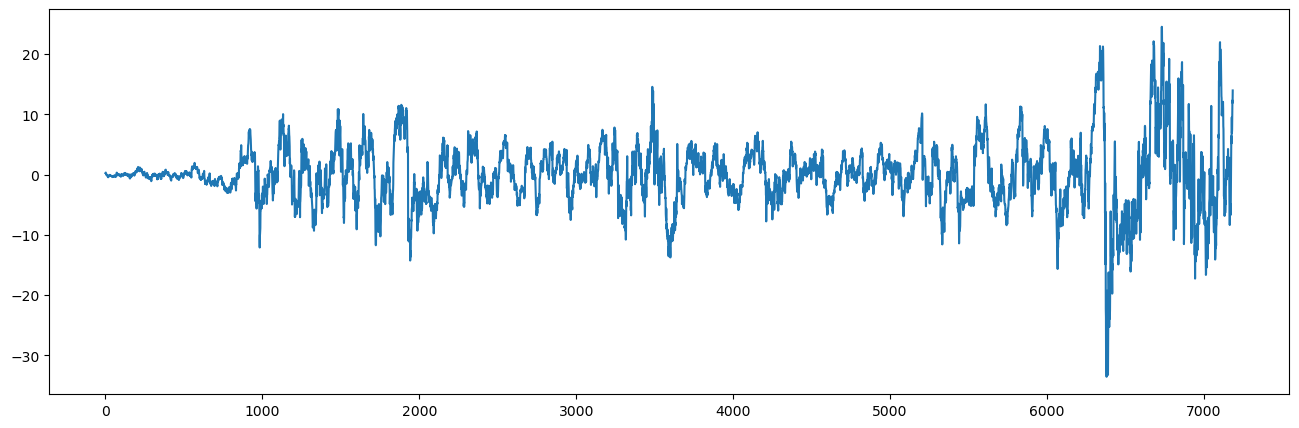

In [13]:
detrended = y_hist['Adj Close'].to_numpy() - results.trend.to_numpy()

plt.figure(figsize=(16,5))
plt.plot(detrended)

# Creating forecasting models

In [14]:
model = ARIMA(y_hist['Adj Close'], order=(1, 2, 1))
fit_model = model.fit()
forecast = fit_model.forecast(len(y_future))
y_future['PredictedARIMA'] = forecast.values

C:\Users\micls\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\micls\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\micls\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\micls\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\U

In [15]:
stl_forecast = STLForecast(y_hist['Adj Close'], model=AutoReg,model_kwargs=dict(lags=1)
, period=200)
stl_forecast_fit = stl_forecast.fit()

C:\Users\micls\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [16]:
STLforecast = stl_forecast_fit.forecast(len(y_future))

C:\Users\micls\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\micls\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\micls\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [17]:
y_future
y_future['PredictedSTL'] = STLforecast.values

C:\Users\micls\AppData\Local\Temp\ipykernel_30488\1514652684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_future['PredictedSTL'] = STLforecast.values


In [18]:
y_future

,Adj Close,PredictedARIMA,PredictedSTL
Date,,,
2023-06-01,105.068680,105.040302,97.061357
2023-06-02,109.271828,105.055292,95.856216
2023-06-05,107.798256,105.069359,96.799326
2023-06-06,110.784950,105.083445,95.403300
2023-06-07,112.288200,105.097531,94.195619
...,...,...,...
2024-01-18,124.919998,107.266734,87.467513
2024-01-19,127.980003,107.280820,85.555497
2024-01-22,129.679993,107.294906,85.964566


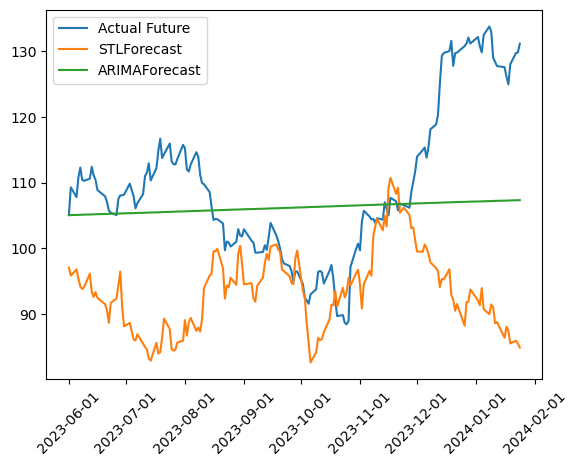

In [19]:
#plt.plot(y_hist['Adj Close'], label = 'historical')
plt.plot(y_future['Adj Close'], label = 'Actual Future')
plt.plot(y_future['PredictedSTL'], label = 'STLForecast')
plt.plot(y_future['PredictedARIMA'], label = 'ARIMAForecast')
#plt.plot(results.trend)
plt.xticks(rotation=45)
desired_ticks = 5
x_ticks = plt.xticks()[0]
selected_ticks = x_ticks[::len(x_ticks) // desired_ticks]
plt.xticks(selected_ticks)
plt.legend()

# Evaluation

In [20]:
stl_err = mean_squared_error(y_future['Adj Close'], y_future['PredictedSTL'],squared = False)
ARIMA_err = mean_squared_error(y_future['Adj Close'], y_future['PredictedARIMA'], squared = False)
print("STL Forecast error: %f" % stl_err )
print('ARIMA Forecast error: %f' % ARIMA_err )

STL Forecast error: 21.101977
ARIMA Forecast error: 11.595726
